In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import matplotlib.pyplot as plt

In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [4]:
tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY', 'GOOGl']  # Example tickers
start_date = '2013-01-01'
end_date = '2019-01-01'
df = yf.download(tickers, start=start_date, end=end_date)['Close']

[*********************100%%**********************]  12 of 12 completed


In [5]:
df.tail()

Ticker,AAPL,ADBE,AMD,EBAY,GOOGL,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,,
2018-12-24,36.707500,205.160004,16.650000,26.139999,49.233501,19.379999,102.839386,25.559999,94.129997,42.689999,53.650002,234.339996
2018-12-26,39.292500,222.949997,17.900000,27.850000,52.392502,20.330000,106.491394,26.600000,100.559998,44.590000,55.959999,246.179993
2018-12-27,39.037498,225.139999,17.490000,28.030001,52.645000,20.379999,108.776291,26.799999,101.180000,44.970001,56.090000,248.070007
2018-12-28,39.057499,223.130005,17.820000,28.240000,52.334000,20.340000,108.059273,26.750000,100.389999,44.820000,56.810001,247.750000
2018-12-31,39.435001,226.240005,18.459999,28.070000,52.248001,20.459999,108.671127,26.910000,101.570000,45.150002,56.910000,249.919998


[('AAPL', 'ORCL'), ('AAPL', 'SPY'), ('ADBE', 'MSFT'), ('AMD', 'MSFT'), ('HPQ', 'ORCL'), ('ORCL', 'SPY')]


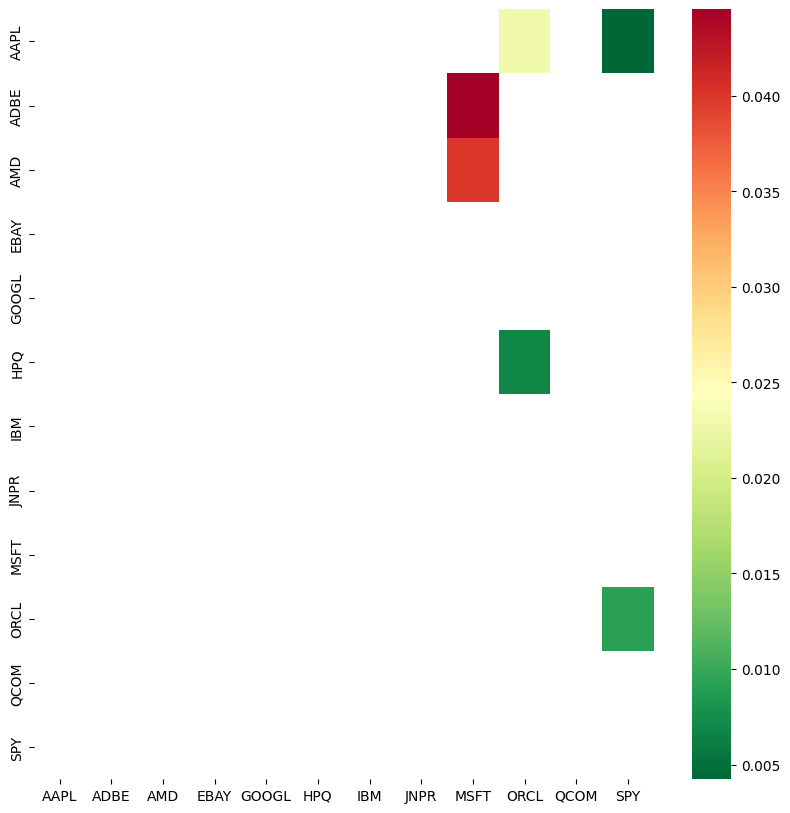

In [6]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [7]:
S1 = df['AAPL']
S2 = df['ORCL']

score, pvalue, _ = coint(S1, S2)
pvalue

0.022941821806030323

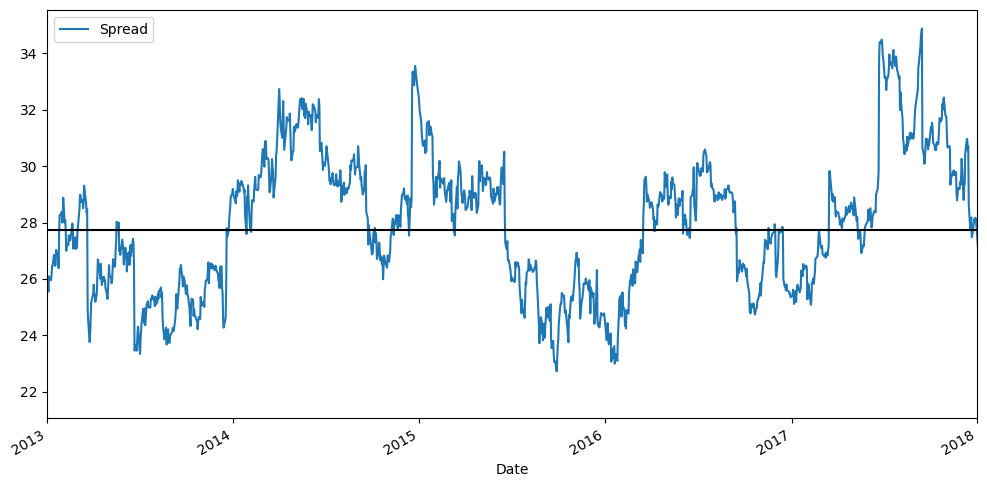

In [8]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['AAPL']
b = results.params['AAPL']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread']);

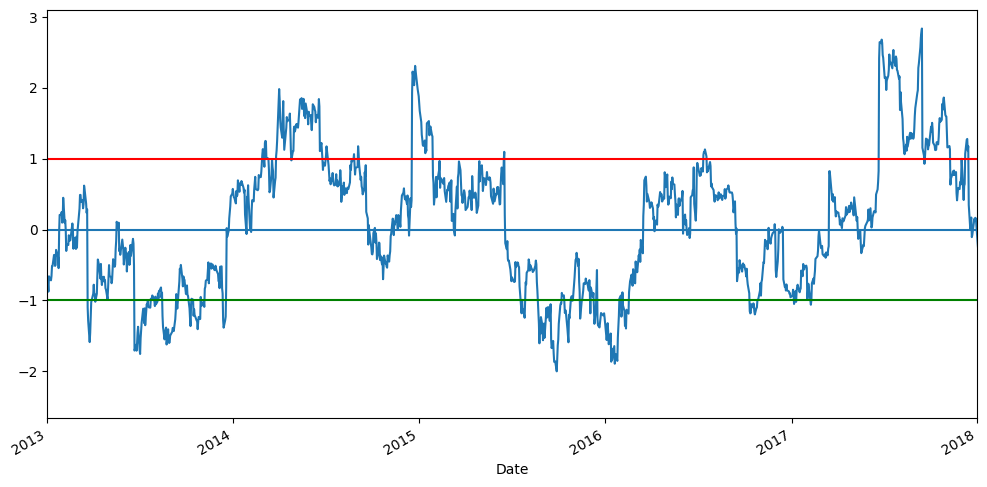

In [9]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(spread).plot(figsize=(12,6))
plt.axhline(zscore(spread).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2018-01-01')
plt.show()

In [10]:
ratios = df['AAPL'] / df['ORCL'] 
print(len(ratios) * .70 ) 

1057.0


In [11]:
train = ratios[:1057]
test = ratios[1057:]

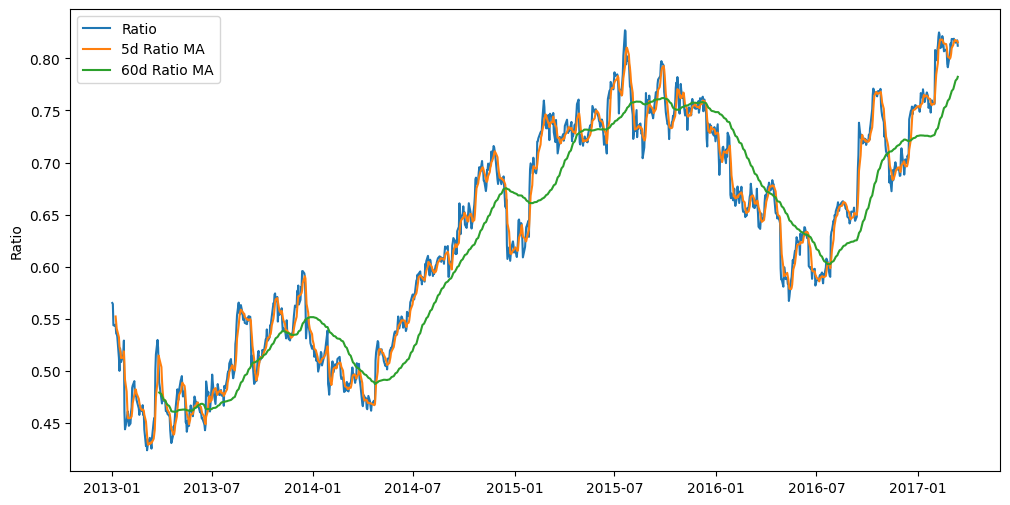

In [12]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

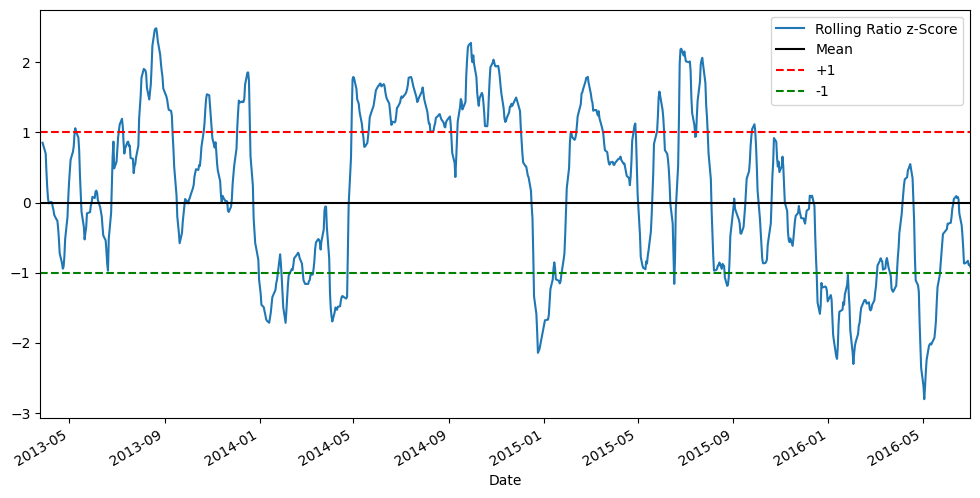

In [13]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2013-03-25', '2016-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

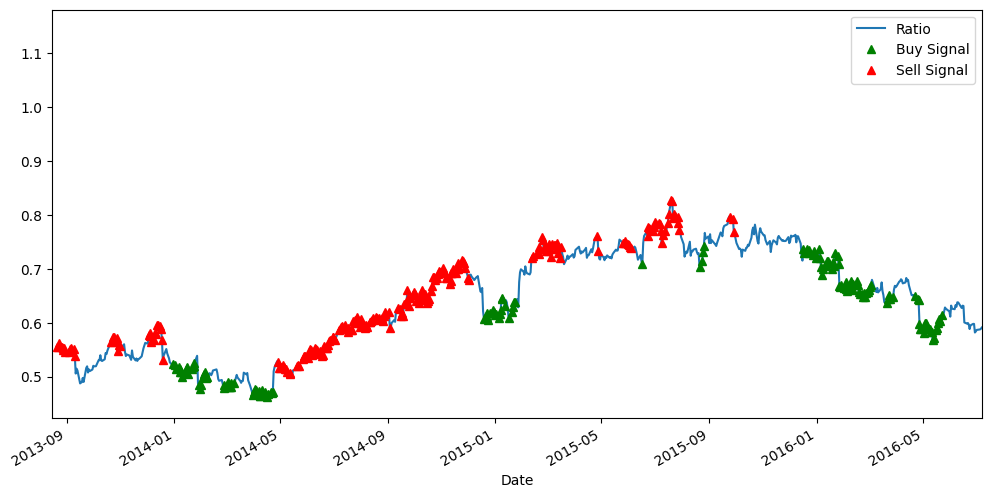

In [14]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

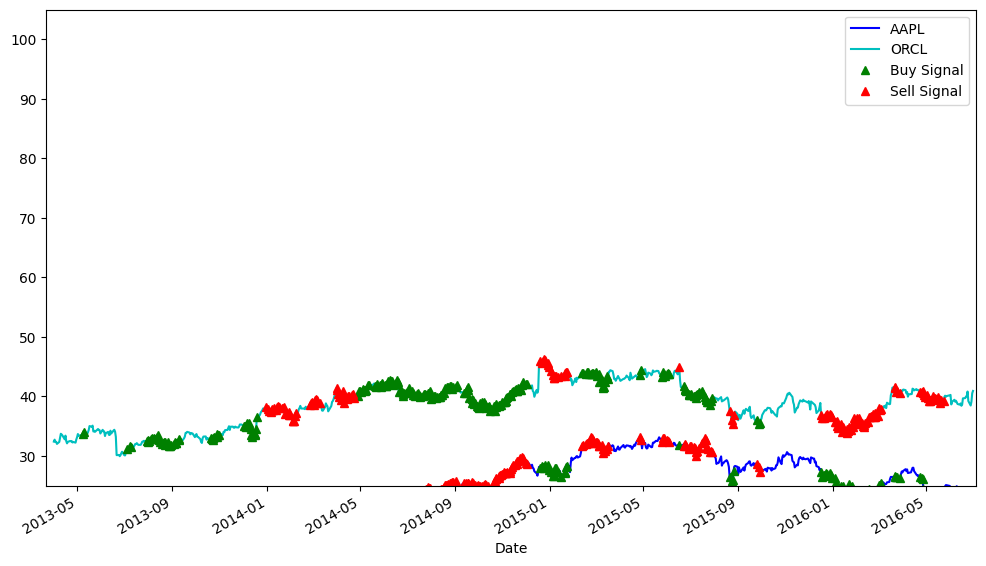

In [15]:
plt.figure(figsize=(12,7))
S1 = df['AAPL'].iloc[:881]
S2 = df['ORCL'].iloc[:881]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 105)
plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['AAPL', 'ORCL', 'Buy Signal', 'Sell Signal'])
plt.show()